In [27]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')
from fbprophet import Prophet as proph
import numpy as np

In [108]:
def plot_model(df, stats_df, zipcode):
    """Plots a single model
    
    Args: 
        df: a data frame with columns [RegionID, RegionName, City, State, Metro,
        CountyName, SizeRank, 1996-04, 1996-05, 1996-06... 2018-02, 2018-03, 2018-04]
        stats_df: a data frame with columns [zipcode, 2018-04-01, minimum, min_roi, 
        expected, expected_roi, maximum, max_roi]
        zipcode: zipcode
    Returns:
        figure with the data from the zipcodes plotted
    """
    model, forecast, zipcode = model_price(df, zipcode, '2005-04-01', '2018-04-01')
    zip_data = df.loc[df['RegionName'] == zipcode]
    stats_data = stats_df.loc[stats_df['zipcode'] == zipcode]
    model.plot(forecast, uncertainty=True)
    title = (f"Zipcode: {zipcode} City: {zip_data['City'].values[0]}"
        + f", {zip_data['State'].values[0]}"
        + f"({zip_data['Metro'].values[0]}"
        + f") -- forecasted ROI: {round(stats_data['expected_roi'].values[0], 3)} "
        + f"80% CI: ({round(stats_data['min_roi'].values[0], 3)}"
        + f", {round(stats_data['max_roi'].values[0], 3)}"
        + f")")
    plt.title(title)
    plt.ylabel = 'price'
    plt.xlabel = 'year'
    plt.show()

In [198]:
def plot_models(df, stats_df, zipcodes, title):
    """
    Plots a single model
    
    Args: 
        df: a data frame with columns [RegionID, RegionName, City, State, Metro,
        CountyName, SizeRank, 1996-04, 1996-05, 1996-06... 2018-02, 2018-03, 2018-04]
        stats_df: a data frame with columns [zipcode, 2018-04-01, minimum, min_roi, 
        expected, expected_roi, maximum, max_roi]
        zipcode: zipcode
    Returns:
        figure with the data from the zipcodes plotted
    """
    palette = plt.get_cmap('Dark2')
    fig, ax = plt.subplots(figsize=(15,8))
    for index, zipcode in enumerate(zipcodes):
        color = palette(index)
        zip_history_df = create_zip_df(df, zipcode, '2005-04-01', '2018-04-01')
        model, forecast, zipcode = model_price(df, zipcode, '2005-04-01', '2018-04-01')
        zip_data = df.loc[df['RegionName'] == zipcode]
        stats_data = stats_df.loc[stats_df['zipcode'] == zipcode]
        label = (f"{zip_data['City'].values[0]}"
                 + f", {zip_data['State'].values[0]}"
                )
        ax.plot(zip_history_df['ds'], zip_history_df['y'], color='k', alpha=0.5)
        ax.plot_date(forecast['ds'], forecast['yhat'], color=color, alpha=.75, label=label) #plot forecast
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                       color=color, alpha=.25) #plot forecast range
        print(f"{zip_data['City']}"
              + f" forecast for 2019-10: "
              + f"{forecast.loc[(forecast['ds'] == '2019-10-01'), ['yhat', 'yhat_lower', 'yhat_upper']]}"
             )
    fig.suptitle(f'Recommended Zipcodes for Real Estate Investment: {title}')
    ax.legend(loc='upper left')
    ax.set_ylabel('price')
    ax.set_xlabel('year')
    fig.show();

In [88]:
all_df = pd.read_csv('raw_data/zillow_data.csv')

In [89]:
all_df.loc[all_df['RegionName'] == 84654]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
13324,94635,84654,Salina,UT,NaN,Sevier,13325,103700.0,103600.0,103400.0,...,165500,165600,165800,165800,164900,164800,164600,164700,164700,164400


In [90]:
all_df.shape[0] - no_nan_df.shape[0]

801

In [91]:
no_nan_df = pd.concat([all_df['RegionName'], all_df.loc[:, '2005-04': '2018-04']], axis=1).dropna()
no_nan_df['RegionName'].head(1)

0    60657
Name: RegionName, dtype: int64

In [92]:
all_df['RegionName'].head(1)

0    60657
Name: RegionName, dtype: int64

In [93]:
all_df.loc[:, '2005-04': '2018-04'].head(1)

,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600


In [94]:
all_df.loc[all_df['RegionName']==29405, '2004-09':].T.head(1)

,4309
2004-09,NaN


In [95]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [127]:
def create_zip_df(df, zipcode, start, end):
    df = melt_data(df.loc[df['RegionName'] == zipcode])
    df = df.reset_index()
    df.columns = ['ds', 'y']
    data_df = df.loc[(df['ds'] > start) & (df['ds'] < end)]
    return data_df

In [128]:
def model_price(df, zipcode, start, end, periods=60, freq='MS', interval_width=0.80):
    """

    """
    data = create_zip_df(df, zipcode, start, end)
    Model = proph(interval_width=interval_width, weekly_seasonality=False, 
                  daily_seasonality=False)
    Model.fit(data)
    future_dates = Model.make_future_dataframe(periods=periods, freq=freq)
    forecast = Model.predict(future_dates)
    return Model, forecast, zipcode

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


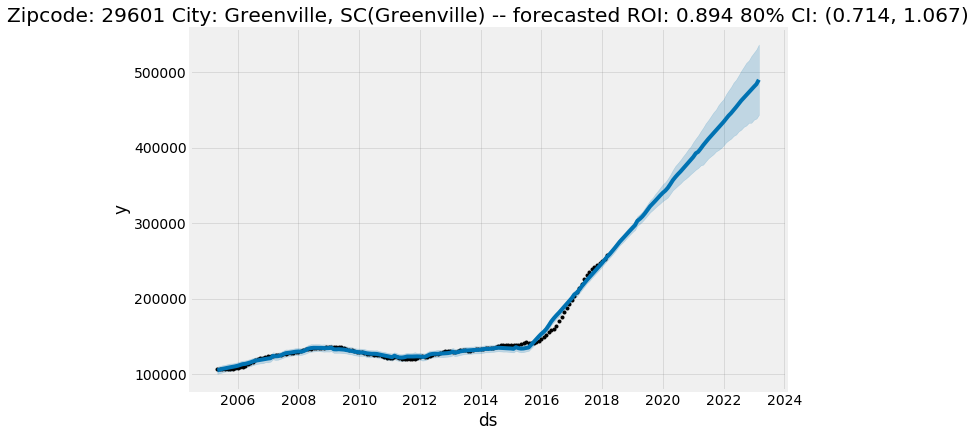

In [105]:
plot_model(all_df, stats_df, 29601)

In [60]:
stats_df = pd.read_csv('raw_data/stats.csv')

In [61]:
stats_df.head()

,Unnamed: 0,zipcode,2018-04-01,minimum,min_roi,expected,expected_roi,maximum,max_roi
0,0,60657.0,1.037784e+06,1.070844e+06,0.031856,1.235148e+06,0.190178,1.400055e+06,0.349082
1,0,75070.0,3.236488e+05,3.373065e+05,0.042199,4.194053e+05,0.295865,5.000079e+05,0.544909
2,0,77494.0,3.235428e+05,2.682185e+05,-0.170995,3.284879e+05,0.015284,3.890296e+05,0.202405
3,0,60614.0,1.318618e+06,1.200312e+06,-0.089720,1.523798e+06,0.155602,1.811421e+06,0.373727
4,0,79936.0,1.199760e+05,9.510128e+04,-0.207331,1.301318e+05,0.084649,1.682291e+05,0.402189


In [63]:
filtered_stats_df = stats_df.loc[stats_df['zipcode'].isin(no_nan_df['RegionName'])]


In [182]:
conservative5 = filtered_stats_df.nlargest(5, 'min_roi')
conservative5

,Unnamed: 0,zipcode,2018-04-01,minimum,min_roi,expected,expected_roi,maximum,max_roi
6698,0,29601.0,258638.364509,443344.806296,0.714149,489904.265675,0.894167,534706.042342,1.067389
3157,0,75234.0,238714.471709,398796.551429,0.670601,431148.939508,0.806128,470908.002437,0.972683
3795,0,75224.0,154626.016415,258311.031721,0.670553,286294.568517,0.851529,309818.769862,1.003665
7981,0,27601.0,279042.267747,463695.028026,0.661738,503906.684333,0.805844,540607.696879,0.937368
5323,0,75235.0,180698.814712,298489.913875,0.651864,323096.247915,0.788037,349234.995235,0.932691


In [190]:
moderate5 = filtered_stats_df.nlargest(5, 'expected_roi')
moderate5

,Unnamed: 0,zipcode,2018-04-01,minimum,min_roi,expected,expected_roi,maximum,max_roi
4135,0,33563.0,1.528269e+05,2.206014e+05,0.443472,2.917412e+05,0.908965,3.627985e+05,1.373918
6698,0,29601.0,2.586384e+05,4.433448e+05,0.714149,4.899043e+05,0.894167,5.347060e+05,1.067389
3795,0,75224.0,1.546260e+05,2.583110e+05,0.670553,2.862946e+05,0.851529,3.098188e+05,1.003665
2596,0,32211.0,1.410498e+05,2.119523e+05,0.502677,2.591417e+05,0.837235,3.016168e+05,1.138371
191,0,7302.0,1.525514e+06,2.476980e+06,0.623702,2.802050e+06,0.836791,3.142064e+06,1.059676


In [188]:
potential5 = filtered_stats_df.nlargest(5, 'max_roi')
potential5

,Unnamed: 0,zipcode,2018-04-01,minimum,min_roi,expected,expected_roi,maximum,max_roi
2409,0,33404.0,137212.816327,116412.847291,-0.151589,247852.017539,0.806333,383534.044138,1.795177
3342,0,95210.0,247781.881136,129969.311582,-0.475469,377423.557260,0.523209,639428.097098,1.580609
4149,0,48506.0,21338.510102,4699.588027,-0.779760,29668.391848,0.390368,55042.141680,1.579474
4436,0,33936.0,136771.343623,102384.722369,-0.251417,230583.865098,0.685908,352329.559760,1.576048
1154,0,33068.0,218786.911781,190830.148417,-0.127781,374135.226080,0.710044,561376.101551,1.565858


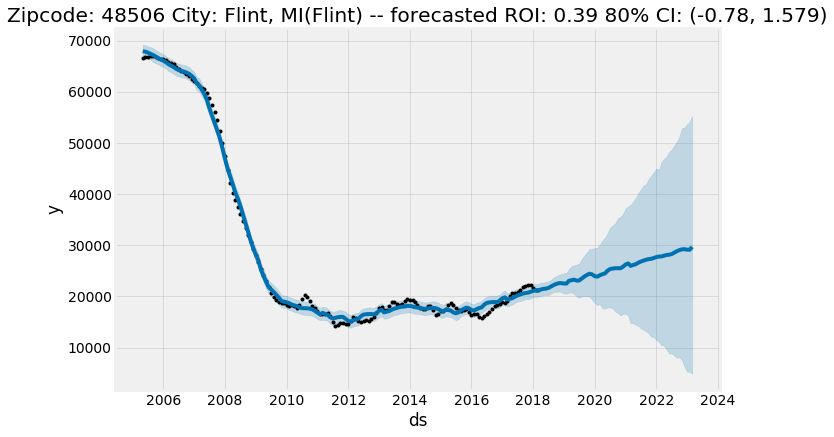

In [189]:
plot_model(all_df, stats_df, 48506)

6698    Greenville
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  329236.534786  320690.261974  338256.576103
3157    Farmers Branch
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  297938.473341  291742.472648  304655.884123
3795    Dallas
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  195173.633214  190824.373816  199410.764801
7981    Raleigh
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  347496.000278  339889.223934  355002.850319
5323    Dallas
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  225056.353851  219253.885946  230861.107407


//anaconda3/envs/zillow-env/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


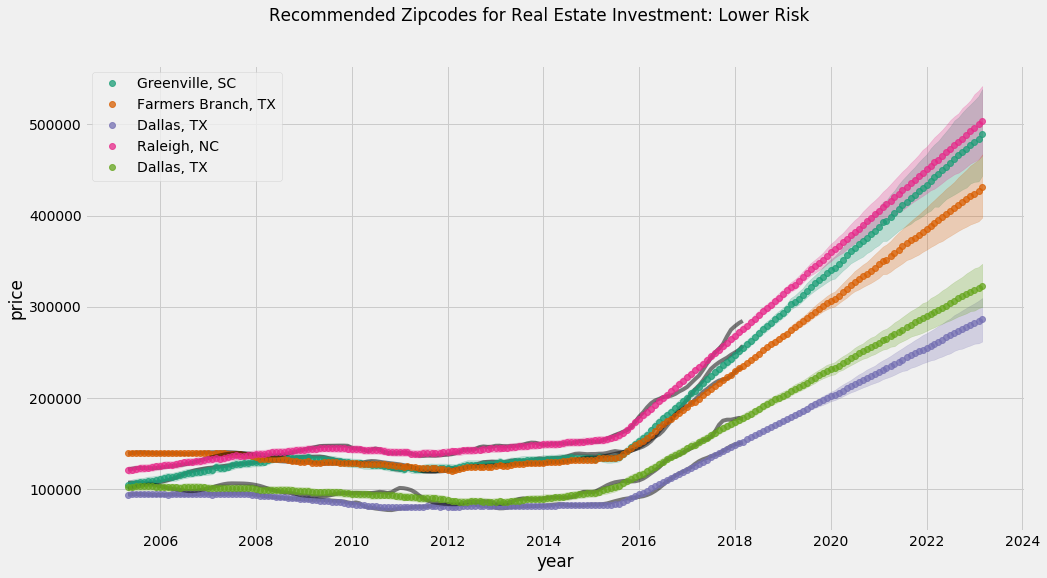

In [199]:
plot_models(all_df, stats_df, conservative5['zipcode'], 'Lower Risk')

4135    Plant City
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  195184.554291  183750.166379  208054.183859
6698    Greenville
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  329236.534786  320607.438242  338203.874625
3795    Dallas
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower    yhat_upper
173  195173.633214  190317.473186  199706.21489
2596    Jacksonville
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  177741.062716  168614.712243  186496.697436
191    Jersey City
Name: City, dtype: object forecast for 2019-10:              yhat    yhat_lower    yhat_upper
173  1.917502e+06  1.854620e+06  1.982499e+06


//anaconda3/envs/zillow-env/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


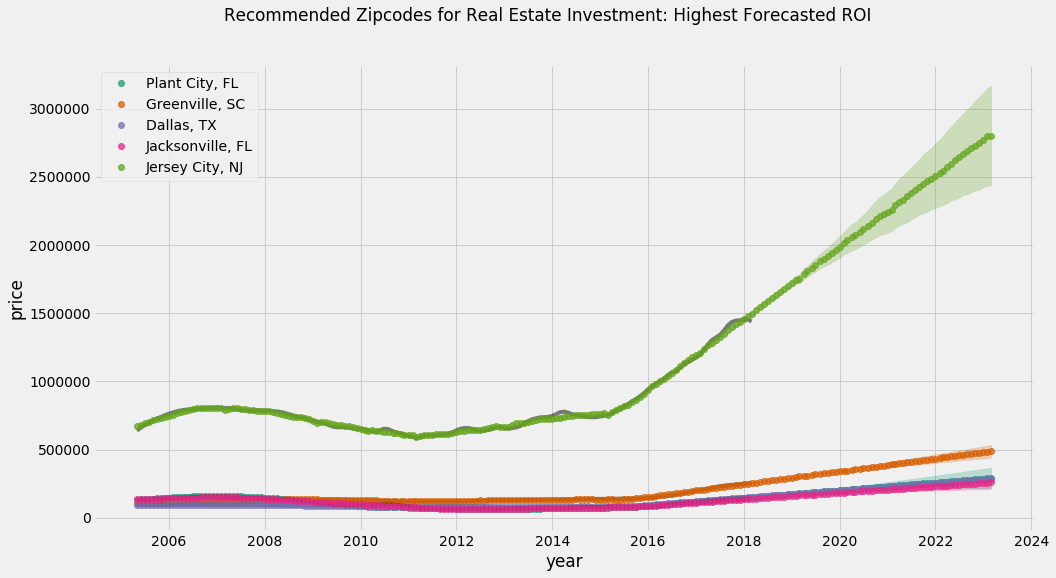

In [200]:
plot_models(all_df, stats_df, moderate5['zipcode'], "Highest Forecasted ROI")

2409    Riviera Beach
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  171754.508362  150822.199676  192613.792136
3342    Stockton
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  287966.777765  245584.375208  325768.281014
4149    Flint
Name: City, dtype: object forecast for 2019-10:              yhat    yhat_lower    yhat_upper
173  24193.500532  19780.723401  28506.659533
4436    Lehigh Acres
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower     yhat_upper
173  165843.082298  146006.280451  186503.893419
1154    North Lauderdale
Name: City, dtype: object forecast for 2019-10:               yhat     yhat_lower    yhat_upper
173  266986.270654  238512.202908  299952.64868


//anaconda3/envs/zillow-env/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


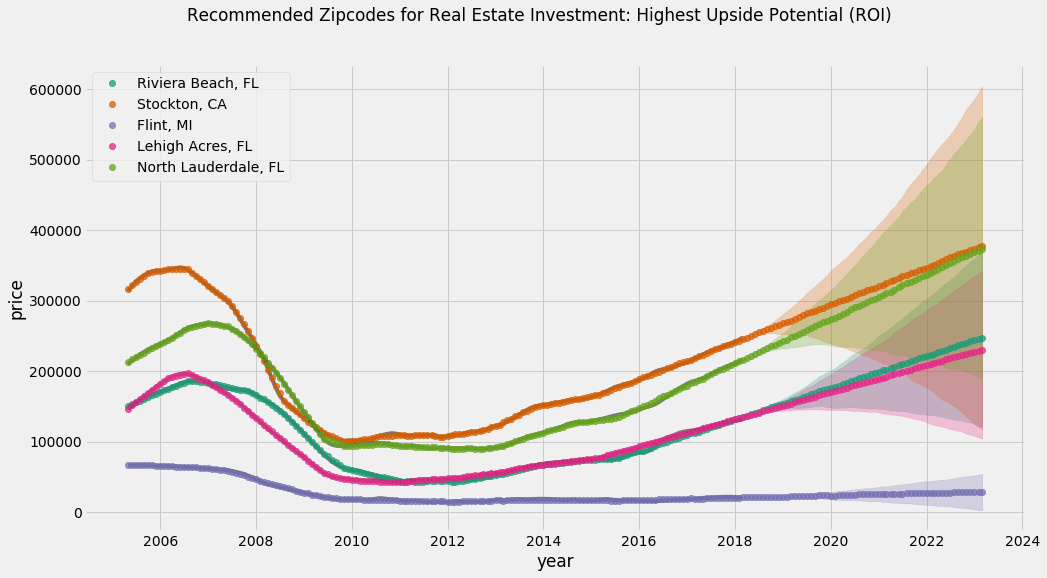

In [201]:
plot_models(all_df, stats_df, potential5['zipcode'], 'Highest Upside Potential (ROI)')